In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Обработка данных

In [2]:
test_data = pd.read_excel('./task_data.xlsx')

main_data = test_data.copy()

In [3]:
main_data.head(2)

,TIME_AG_OUTBOUND,TIME_AG_WORK,TIME_AG_INBOUND,NUM_C_OUTB,NUM_C_INBOUND,TIME_AG_LOGIN,TIME_KEY,TIME_AG_NOT_READY,PRESENTATION_NAME
0,0,0,0,0,0,0,2020043023MSK,0,"Иванова Натали Ивановна 01.07.15, MSK #MID2N"
1,0,0,0,0,0,0,2020043022MSK,0,"Иванова Натали Ивановна 01.07.15, MSK #MID2N"


In [4]:
# функции для извлечения нужного из PRESENTATION_NAME
# не знаю по какому принципу сохраняются данные, потому тут обошел конкретные моменты из кейса, можно оптимизировать : )

def get_group(x):
    splited = x.split(', ')
    return splited[1][4:10]

def get_city(x):
    splited = x.split(', ')
    if splited[1] == 'MSL #MID2N':
        return 'MSK #MID2N'
    return splited[1][:4]

def get_name(x):
    no_inv = x.replace('\xa0', ' ')
    splited = no_inv.split(' ')
    name_container = []
    for i in splited:
        if i[0].isalpha() and i[0].isupper():
            name_container.append(i.strip(',')) 
        if len(name_container) == 3:
            return (' '.join(name_container))


In [5]:
main_data['GROUP'] = main_data['PRESENTATION_NAME'].apply(get_group)
main_data['CITY'] = main_data['PRESENTATION_NAME'].apply(get_city)
main_data['NAME'] = main_data['PRESENTATION_NAME'].apply(get_name)

final_data = main_data.loc[~main_data['TIME_AG_LOGIN'].isin([0])]
final_data = final_data.drop('PRESENTATION_NAME', axis=1).reset_index()

In [6]:
final_data.head(2)

,index,TIME_AG_OUTBOUND,TIME_AG_WORK,TIME_AG_INBOUND,NUM_C_OUTB,NUM_C_INBOUND,TIME_AG_LOGIN,TIME_KEY,TIME_AG_NOT_READY,GROUP,CITY,NAME
0,27,0,0,0,0,0,25,2020042920MSK,5,#MID2N,MSK,Иванова Натали Ивановна
1,28,281,48,0,10,0,3600,2020042919MSK,0,#MID2N,MSK,Иванова Натали Ивановна


In [7]:
final_data.to_excel('./excel_forms/general_data.xlsx')

### task_1

Агрегировать данные по месяцам, вывести ФИО/PRESENTATION_NAME сотрудника с самым низким Средним временем разговора (на обоих линиях) из каждой группы за Апрель, сохранить результаты в excel файл. 

In [8]:
t1 = pd.read_excel('./excel_forms/general_data.xlsx')

In [9]:
def get_date(x, period):
    y = x[:4]
    m = x[4:6]
    d = x[6:8]
    h = x[8:10]
    ymd = y + m + d
    ymdh = y + m + d + h
    match period:
        case 'y':
            return y
        case 'm':
            return m
        case 'd':
            return d
        case 'h':
            return h
        case 'ymd':
            return ymd
        case 'ymdh':
            return ymdh

In [10]:
t1['YEAR'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'y'))
t1['MONTH'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'m'))
t1['DAY'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'d'))
t1['HOURS'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'h'))
t1['DATE_FORMAT'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'ymd'))
t1['DATE_HOURS_FORMAT'] = t1['TIME_KEY'].apply(lambda x: get_date(x,'ymdh'))

In [11]:
gr_months = t1.groupby(['MONTH', 'GROUP', 'NAME']).sum(['TIME_AG_OUTBOUND', 'TIME_AG_INBOUND']).reset_index()
gr_months['TOTAL_TIME_AVG'] = (gr_months['TIME_AG_OUTBOUND'] + gr_months['TIME_AG_INBOUND']) / 2
agg_func = {'TOTAL_TIME_AVG': ['min']}
lowest_by_group = (gr_months.sort_values(by='TOTAL_TIME_AVG').groupby(['MONTH', 'GROUP']).agg(agg_func))


In [12]:
lowest_by_group

TOTAL_TIME_AVG
                        min
MONTH GROUP                
04    #MID16        96507.0
      #MID2N        17016.5
      #MID5N        57934.5

In [13]:
# пока немного сложно с уровнями вложенности в пандах, оставлю результат с фамилиями из экселя


![task1](./task1_min_time_by_groups.JPG)

In [14]:
t1.to_excel('./excel_forms/t1_min_time_by_group.xlsx')

### task_2
Построить график среднего времени разговора по дням за Апрель

In [15]:
t2 = t1.copy()

In [16]:
t2['DATE'] = t2['TIME_KEY'].apply(lambda x: get_date(x,'ymd'))
t2['DATE'] = pd.to_datetime(t2['DATE']).dt.date
t2['TOTAL_TIME_AVG'] = (t2['TIME_AG_OUTBOUND'] + t2['TIME_AG_INBOUND']) / 2

In [17]:
avg_dur_by_months = t2.groupby(['DATE']).agg({'TOTAL_TIME_AVG': 'mean'}).reset_index()

In [18]:
t2.to_excel('./excel_forms/t2_avg_calls_duration.xlsx')

In [19]:
avg_dur_by_months.head(2)

,DATE,TOTAL_TIME_AVG
0,2020-04-01,566.614130
1,2020-04-02,578.853093


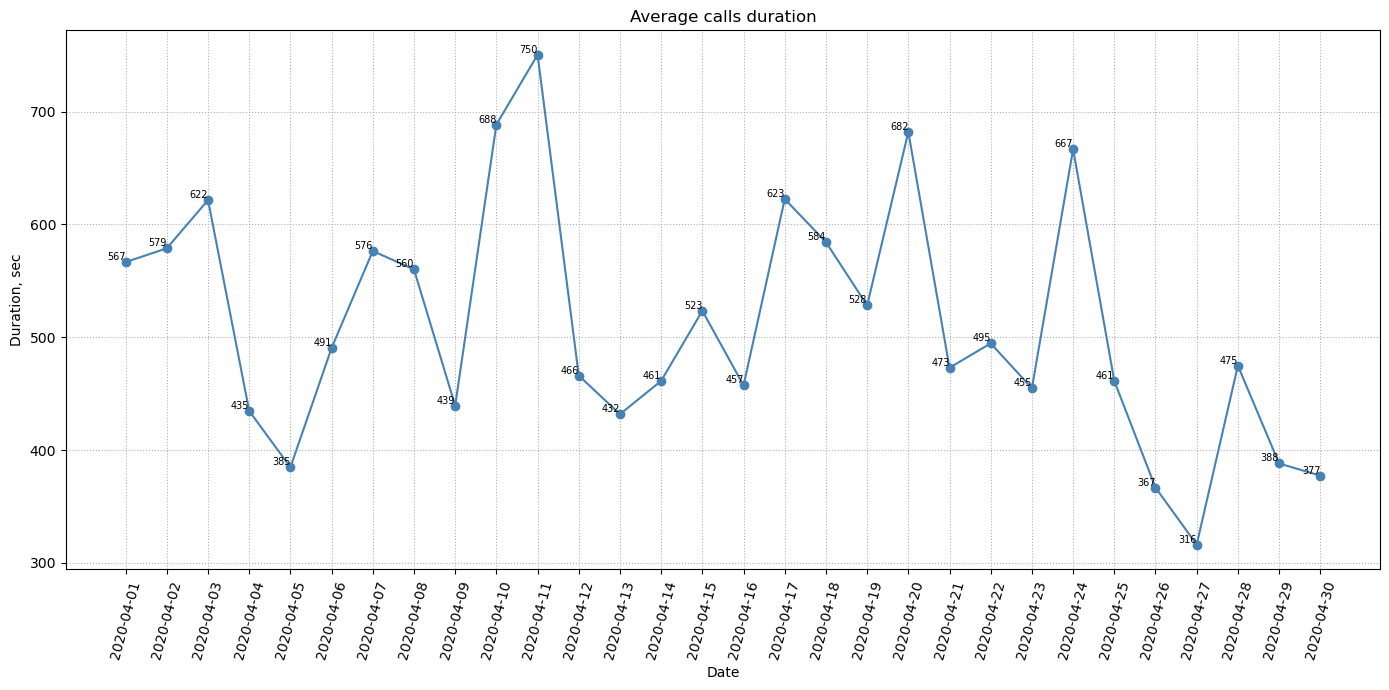

In [20]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(avg_dur_by_months['DATE'],
        avg_dur_by_months['TOTAL_TIME_AVG'],
        marker="o",
        color = 'steelblue')

for x, y in zip(avg_dur_by_months['DATE'], avg_dur_by_months['TOTAL_TIME_AVG']):
    plt.text(x, y, f"{round(y)}", fontsize=7, ha='right', va='bottom')
    
ax.set(xlabel='Date',
       ylabel='Duration, sec',
       title='Average calls duration')


plt.xticks(avg_dur_by_months['DATE'],
           rotation=75)
ax.grid(axis='both', ls=':')

plt.tight_layout()
plt.savefig('./charts/t2_avg_calls_duration.png')
plt.show()

### task_3
Агрегировать данные по часам, и вывести Среднее время ответа на исходящей линии по часам за Апрель, в течении рабочего времени с 7:00 до 19:00 и сохранить результаты в excel.
Далее построить график подобный графику из задания 2, где на оси x часы, вместо даты, сохранить его 


_Мб неправильная логика построения метрики, но как я понял работу операторов, то есть время в системе TIME_AG_LOGIN, время перерыва TIME_AG_NOT_READY (которое включено в TIME_AG_LOGIN). Часть времени сотрудник работает на входящих вызовах TIME_AG_INBOUND, какое-то время уделяет исходящим звонкам TIME_AG_OUTBOUND.
Потому средннее время ответа считаю по формуле:_

**(Общее время в системе - Время перерывов - (Продолжительность входящих + Продолжительность исходящих)) / Количество исходящих звонков.**

_В процессе столкнулся с ситуациями, где у сотрудников время перерыва больше общего времени лога или общая продолжительность вызовов превышает время в системе. Предполагаю, что могут быть некорректные данные, надо детально разбираться в их происхождении, но в расчете эти отрицательные значения привел к нулям._

In [21]:
t3 = t2.copy()

In [22]:
# откинем записи кроме нужного временного интервала
t3 = t3.loc[~t3['HOURS'].isin(['0', '00', '01', '02', '03', '04', '05', '06', '20', '21', '22', '23', '25'])]

In [23]:
def zero_instead_nagative(x):
    if x < 0:
        return 0
    else:
        return x

In [24]:
# удаляем данные по сотрудникам без исходящих вызовов
t3 = t3.loc[~t3['NUM_C_OUTB'].isin([0])]

# готовим серии для расчета по формуле выше
t3['FULL_WORK_TIME'] = t3['TIME_AG_LOGIN'] - t3['TIME_AG_NOT_READY']
t3['FULL_WORK_TIME'] = t3['FULL_WORK_TIME'].apply(zero_instead_nagative)
t3['TIME_WITHOUT_CALLS'] = t3['FULL_WORK_TIME'] - (t3['TIME_AG_OUTBOUND'] + t3['TIME_AG_INBOUND'])
t3['TIME_WITHOUT_CALLS'] = t3['TIME_WITHOUT_CALLS'].apply(zero_instead_nagative)
t3['AVG_OTBOUND_ANSWER_TIME'] = t3['TIME_WITHOUT_CALLS'] / t3['NUM_C_OUTB']

In [25]:
t3.to_excel('./excel_forms/t3_avg_outbound_answer_time.xlsx')

In [26]:
#агрегируем по часам
avg_out_answer_time = t3.groupby(['HOURS']).agg({'AVG_OTBOUND_ANSWER_TIME': 'mean'}).reset_index()

In [27]:
avg_out_answer_time.head(2)

,HOURS,AVG_OTBOUND_ANSWER_TIME
0,07,185.611404
1,08,107.859268


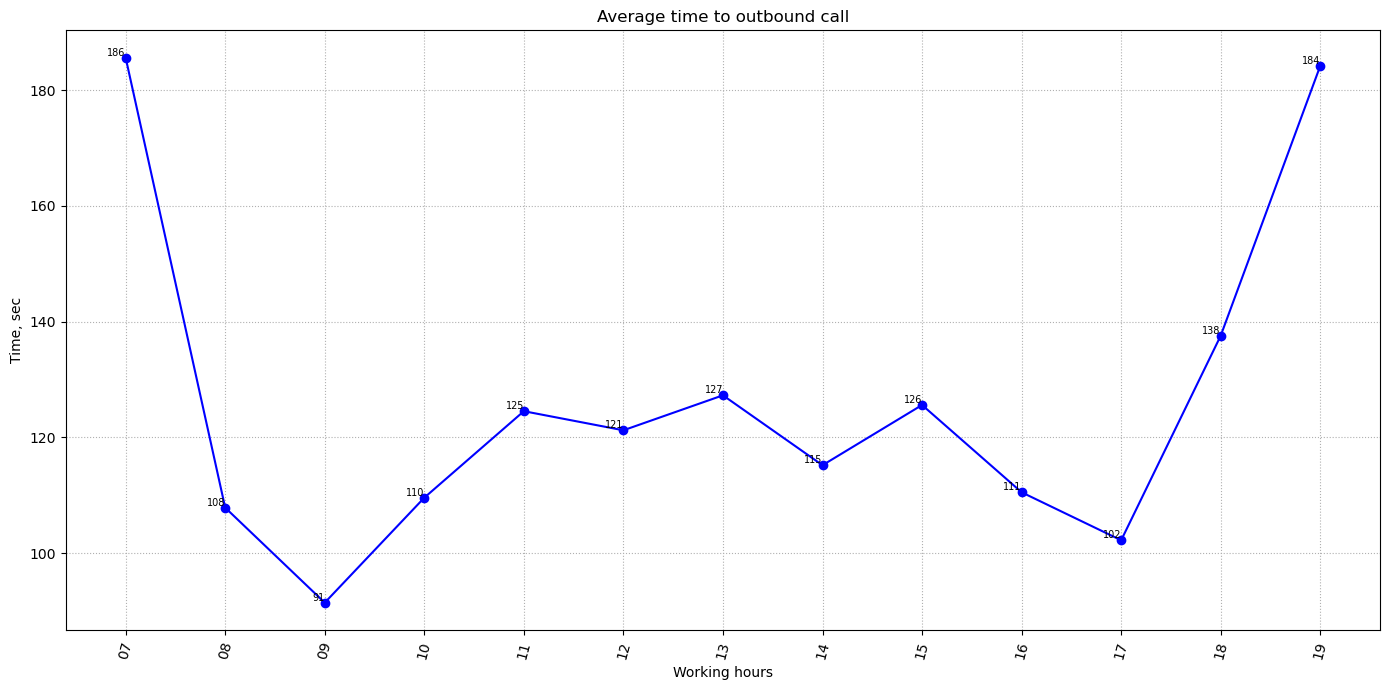

In [28]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(avg_out_answer_time['HOURS'],
        avg_out_answer_time['AVG_OTBOUND_ANSWER_TIME'],
        marker="o",
        color = 'blue')

for x, y in zip(avg_out_answer_time['HOURS'], avg_out_answer_time['AVG_OTBOUND_ANSWER_TIME']):
    plt.text(x, y, f"{round(y)}", fontsize=7, ha='right', va='bottom')
    
ax.set(xlabel='Working hours',
       ylabel='Time, sec',
       title='Average time to outbound call')


plt.xticks(avg_out_answer_time['HOURS'],
           rotation=75)
ax.grid(axis='both', ls=':')

plt.tight_layout()
plt.savefig('./charts/t2_avg_calls_duration.png')
plt.show()

### task_4
Агрегировать данные по общему кол-ву звонков(входящих и исходящих) по дням за Апрель вывести или сохранить в excel и построить график.


In [29]:
t4 = t2.copy()
t4['TOTAL_CALLS'] = t4['NUM_C_OUTB'] + t4['NUM_C_INBOUND']
gr_dates_calls = t4.groupby(['DATE']).sum(['NUM_C_INBOUND', 'NUM_C_OUTB']) 

In [30]:
gr_dates_calls.head(2)

,Unnamed: 0,index,TIME_AG_OUTBOUND,TIME_AG_WORK,TIME_AG_INBOUND,NUM_C_OUTB,NUM_C_INBOUND,TIME_AG_LOGIN,TIME_AG_NOT_READY,TOTAL_TIME_AVG,TOTAL_CALLS
DATE,,,,,,,,,,,
2020-04-01,696518,2710374,180997,17528,27517,3083,208,593635,94492,104257.0,3291
2020-04-02,713034,2767481,192657,18902,31938,3585,262,615946,87764,112297.5,3847


In [31]:
t4.to_excel('./excel_forms/t4_number_of_calls.xlsx')

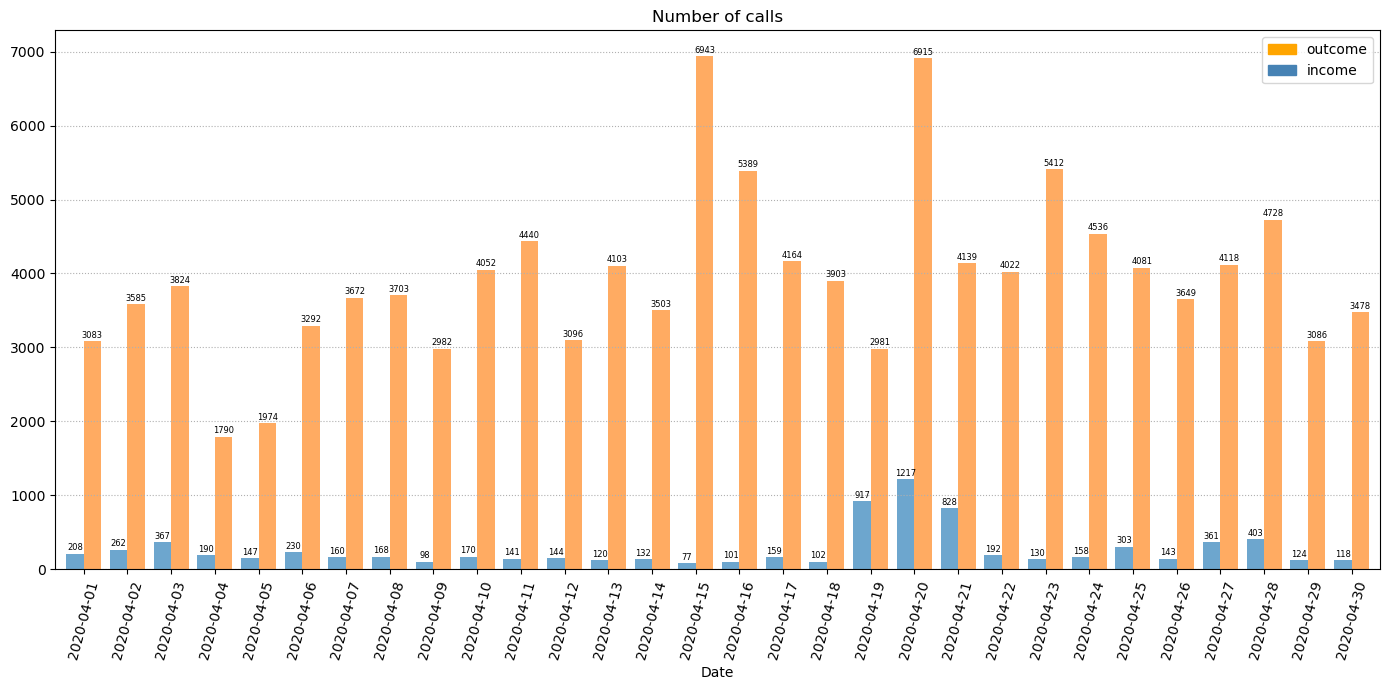

In [32]:
fig, ax = plt.subplots(figsize=(14, 7))

pivot_pltf = gr_dates_calls.pivot_table(index=['DATE'],
                                        values=['NUM_C_INBOUND', 'NUM_C_OUTB']
                                       )
pivot_pltf.plot(kind='bar',
                ax=ax,
                stacked=False,
                width=0.8,
                alpha=0.65
               )

ax.set(xlabel='Date',
       title='Number of calls')

for i in ax.containers:
    ax.bar_label(i,
                 padding=1,
                 fontsize=6,
                 label_type='edge')

plt.xticks(rotation=75)
plt.grid(axis='y', ls=':')

colors = {'outcome':'orange', 'income':'steelblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.tight_layout()
plt.savefig('./charts/t4_number_of_calls.png')
plt.show()

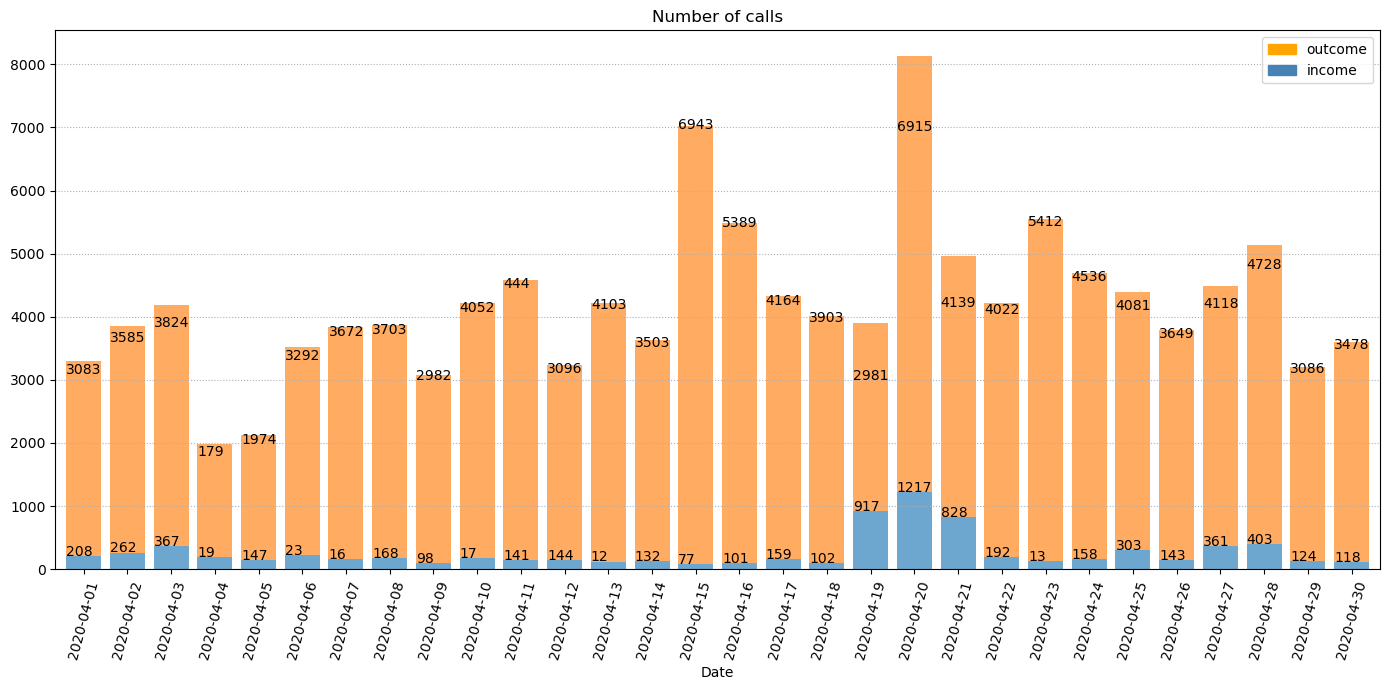

In [33]:
fig, ax = plt.subplots(figsize=(14, 7))

pivot_pltf = gr_dates_calls.pivot_table(index=['DATE'],
                                        values=['NUM_C_INBOUND', 'NUM_C_OUTB'],
                                       )
pivot_pltf.plot(kind='bar',
                ax=ax,
                stacked=True,
                width=0.8,
                alpha=0.65
               )

ax.set(xlabel='Date',
       title='Number of calls')

for p in ax.patches:
    ax.annotate(str(p.get_height()).strip('.0'),  (p.get_x(), p.get_height() * 1.005))

plt.xticks(rotation=75)
plt.grid(axis='y', ls=':')

colors = {'outcome':'orange', 'income':'steelblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.tight_layout()
plt.savefig('./charts/t4_number_of_calls_stacked.png')
plt.show()